<a href="https://colab.research.google.com/github/cleysonl/Pytorch/blob/master/Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Style transfer with PyTorch using VGG19**

In [51]:
!pip install torch torchvision
!pip3 install Pillow==4.0.0

  Using cached https://files.pythonhosted.org/packages/10/5c/0e94e689de2476c4c5e644a3bd223a1c1b9e2bdb7c510191750be74fa786/Pillow-6.2.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.4.1+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.2.1
    Uninstalling Pillow-6.2.1:
      Successfully uninstalled Pillow-6.2.1


In [0]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

## **Initialize Model VGG19**

In [0]:
vgg = models.vgg19(pretrained= True).features

In [0]:
for param in vgg.parameters():
  param.requires_grad_(False)


In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## **Function load_image**

In [0]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB') # we set the color space of the imported image to be a standard 'RGB' image
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

   # transform the uploaded image for the model
  in_transform = transforms.Compose([ transforms.Resize(size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
  
  image = in_transform(image).unsqueeze(0) # unsqueeze(0) to an extra dimensionality to the image
  return image

### **Uploading the pictures for the Style transfer**

In [0]:
content = load_image('fran3.jpeg').to(device)
style = load_image('estilofran2.jpg', shape = content.shape[-2:]).to(device)

### **Function to convert image: im_convert**

In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze() ############ why?????????????
  image = image.transpose(1,2,0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0,1)
  return image


(-0.5, 399.5, 532.5, -0.5)

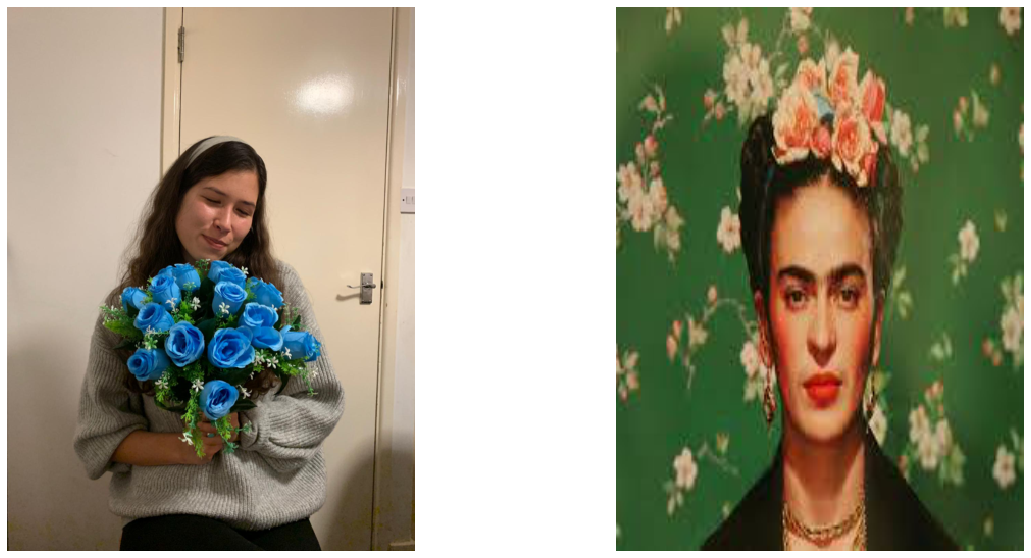

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

## **Function get_features**

In [0]:
def get_features(image, model):
  layers = {'0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2', # content extraction
            '28': 'conv5_1'
            }
  features = {}
  for name, layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
  return features


In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

## **Gram Matrix**

In [0]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

## **Optimization**

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
 
content_weight = 1  # alpha
style_weight = 1e6  # beta

In [0]:
target = content.clone().requires_grad_(True).to(device)

In [0]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 21000
 
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  610803.625
Iteration:  300


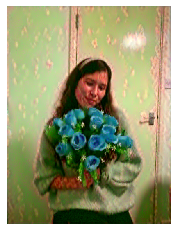

Total loss:  355039.65625
Iteration:  600


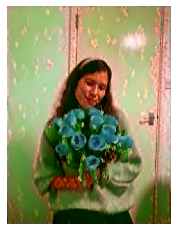

Total loss:  248083.03125
Iteration:  900


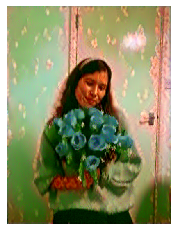

Total loss:  175914.453125
Iteration:  1200


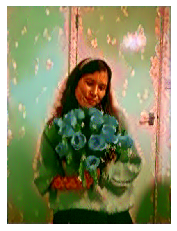

Total loss:  124176.453125
Iteration:  1500


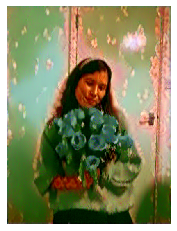

Total loss:  87175.6328125
Iteration:  1800


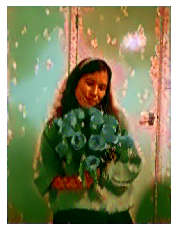

Total loss:  61048.046875
Iteration:  2100


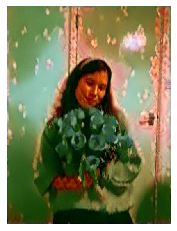

Total loss:  43084.10546875
Iteration:  2400


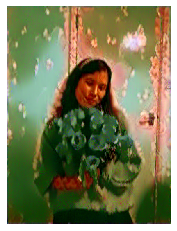

Total loss:  30923.701171875
Iteration:  2700


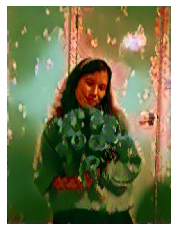

Total loss:  22818.46484375
Iteration:  3000


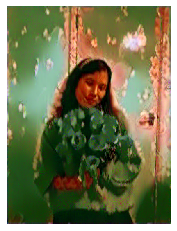

Total loss:  17413.4609375
Iteration:  3300


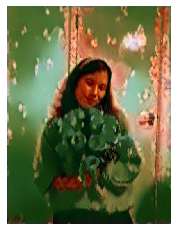

Total loss:  13778.0556640625
Iteration:  3600


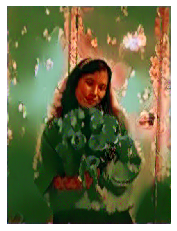

Total loss:  11297.775390625
Iteration:  3900


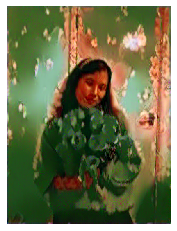

Total loss:  20210.69140625
Iteration:  4200


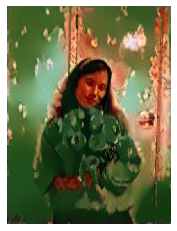

Total loss:  8862.701171875
Iteration:  4500


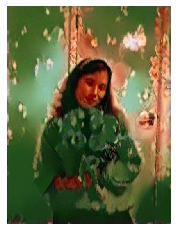

Total loss:  7969.7890625
Iteration:  4800


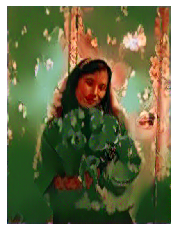

Total loss:  7355.65185546875
Iteration:  5100


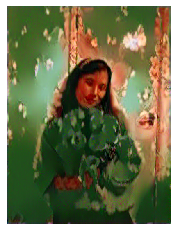

Total loss:  6873.75390625
Iteration:  5400


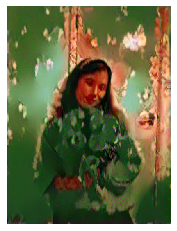

Total loss:  6475.9443359375
Iteration:  5700


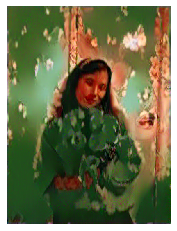

Total loss:  6148.8095703125
Iteration:  6000


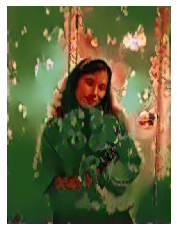

Total loss:  5833.64794921875
Iteration:  6300


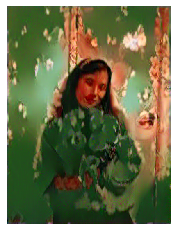

Total loss:  6352.1025390625
Iteration:  6600


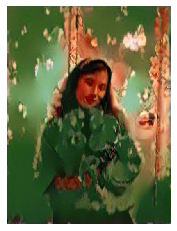

Total loss:  5777.31005859375
Iteration:  6900


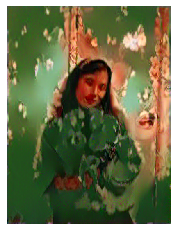

Total loss:  5515.5771484375
Iteration:  7200


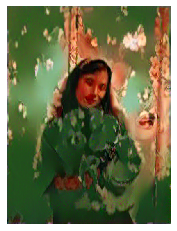

Total loss:  5338.4365234375
Iteration:  7500


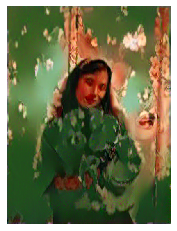

Total loss:  5203.1015625
Iteration:  7800


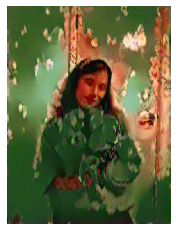

Total loss:  5126.53955078125
Iteration:  8100


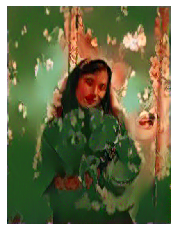

Total loss:  4982.50927734375
Iteration:  8400


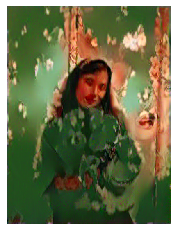

Total loss:  4872.42041015625
Iteration:  8700


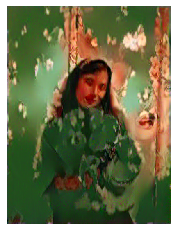

Total loss:  13102.6064453125
Iteration:  9000


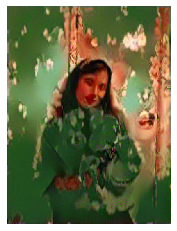

Total loss:  5217.66943359375
Iteration:  9300


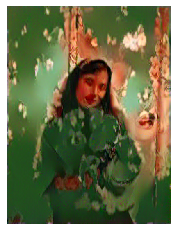

Total loss:  4884.93017578125
Iteration:  9600


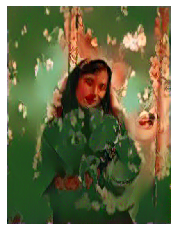

Total loss:  4718.0224609375
Iteration:  9900


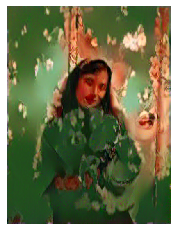

Total loss:  4604.22998046875
Iteration:  10200


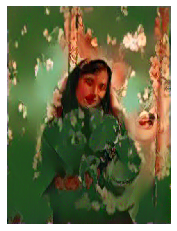

Total loss:  4530.8740234375
Iteration:  10500


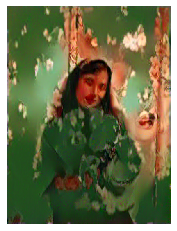

Total loss:  4481.45947265625
Iteration:  10800


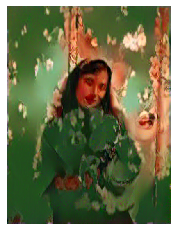

Total loss:  4448.3701171875
Iteration:  11100


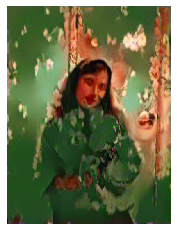

Total loss:  4329.49365234375
Iteration:  11400


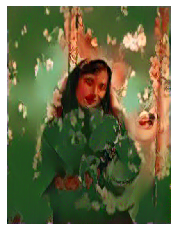

Total loss:  4934.365234375
Iteration:  11700


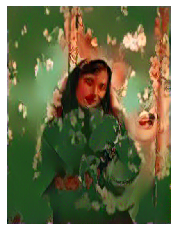

Total loss:  4503.92333984375
Iteration:  12000


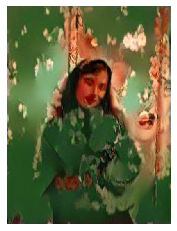

Total loss:  4341.2509765625
Iteration:  12300


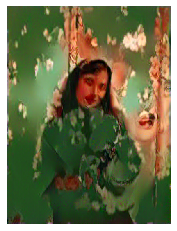

Total loss:  4251.81884765625
Iteration:  12600


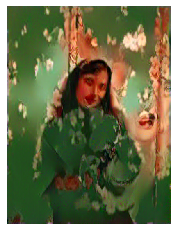

Total loss:  4188.43017578125
Iteration:  12900


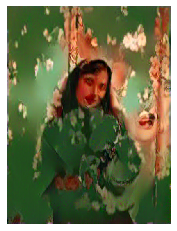

Total loss:  4163.4931640625
Iteration:  13200


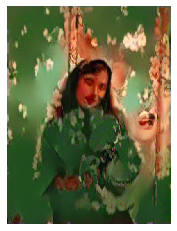

Total loss:  4112.6806640625
Iteration:  13500


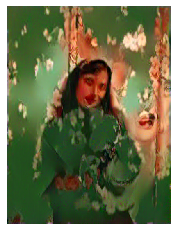

Total loss:  4123.79052734375
Iteration:  13800


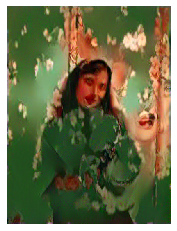

Total loss:  4990.1728515625
Iteration:  14100


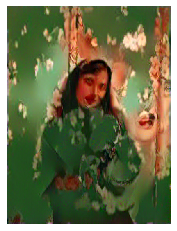

Total loss:  4306.30859375
Iteration:  14400


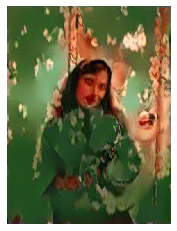

Total loss:  4124.16552734375
Iteration:  14700


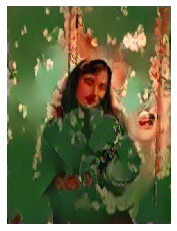

Total loss:  4028.10205078125
Iteration:  15000


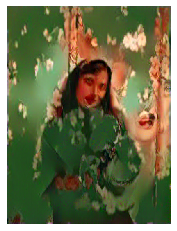

Total loss:  3974.338134765625
Iteration:  15300


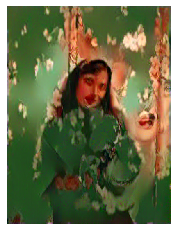

Total loss:  3918.24755859375
Iteration:  15600


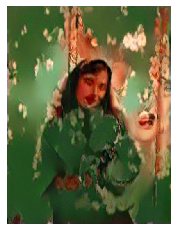

Total loss:  3935.0859375
Iteration:  15900


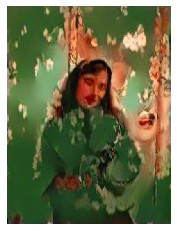

Total loss:  3880.3642578125
Iteration:  16200


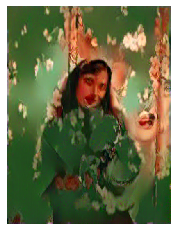

Total loss:  3876.96142578125
Iteration:  16500


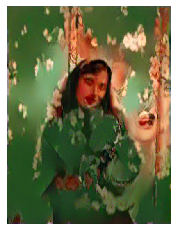

Total loss:  4719.26318359375
Iteration:  16800


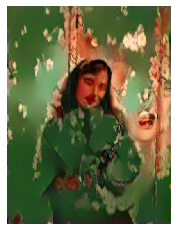

Total loss:  4125.67236328125
Iteration:  17100


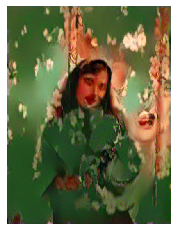

Total loss:  3947.99755859375
Iteration:  17400


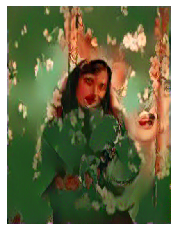

Total loss:  3853.797119140625
Iteration:  17700


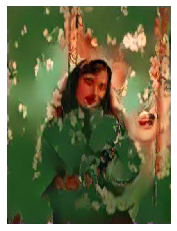

Total loss:  3793.542236328125
Iteration:  18000


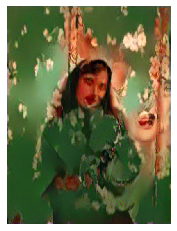

Total loss:  3748.285888671875
Iteration:  18300


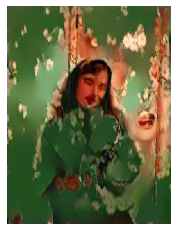

Total loss:  3739.751220703125
Iteration:  18600


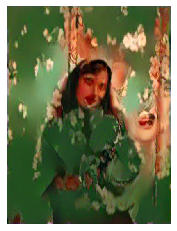

Total loss:  3684.962890625
Iteration:  18900


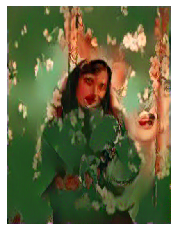

Total loss:  4176.7099609375
Iteration:  19200


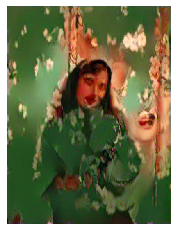

Total loss:  4134.45654296875
Iteration:  19500


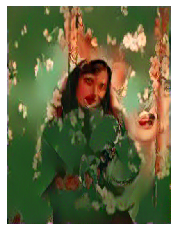

Total loss:  3847.60302734375
Iteration:  19800


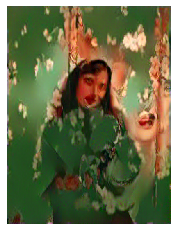

Total loss:  3730.259521484375
Iteration:  20100


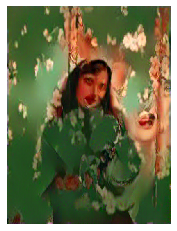

Total loss:  3664.7255859375
Iteration:  20400


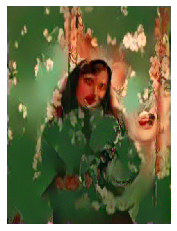

Total loss:  3632.2705078125
Iteration:  20700


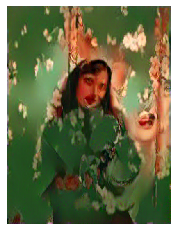

Total loss:  3640.71435546875
Iteration:  21000


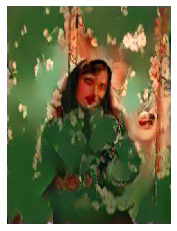

In [67]:
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  style_loss = 0
  
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1

## **Saving the Style transfer into a video**

In [0]:
import cv2 
 
frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))
 
for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)
 
vid.release()

### **Downloading the video**

In [0]:
from google.colab import files
files.download('output.mp4')